In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="6"

Sun Jan 21 21:37:10 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   28C    P0    42W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.spiral_prior import Prior
from model.latent.lse_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [7]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]
hp.M = 1024
hp.N = 256
hp.const_sigma = False

In [8]:
''' Find Optimum Log-Sigma'''
from util.loglikelihood import get_optimum_log_sigma
from util.spiral import generate_spiral_data_torch

p_samples1 = generate_spiral_data_torch(hp.M//5, 5)[0].cuda()
p_samples2 = generate_spiral_data_torch(hp.N//5, 5)[0].cuda()
log_sigmas = np.array([get_optimum_log_sigma(p_samples1, p_samples2) for _ in range(100)])
optimum_log_sigma = np.median(log_sigmas)
print(optimum_log_sigma)

hp.init_log_sigma = optimum_log_sigma

-2.8181818181818183


In [11]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
prior 0.0
latent 3.814697265625e-06
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [12]:
save_dir = '/data/scpark/save/lse/train01.16-6_2try/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 0


### Dataset

In [13]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=hp.N, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [14]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [15]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


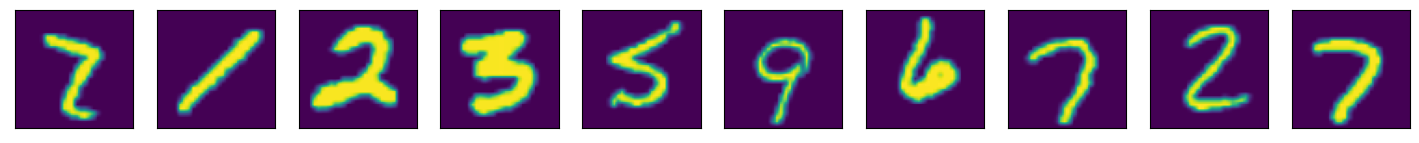

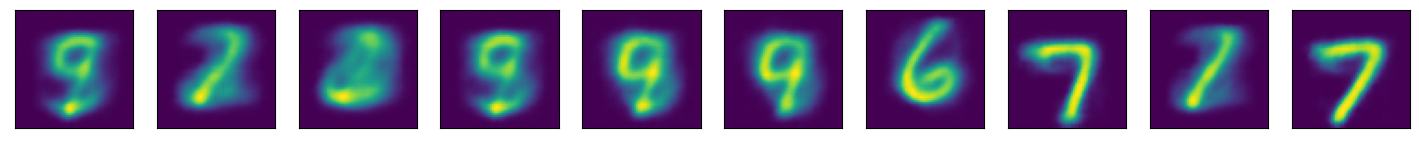

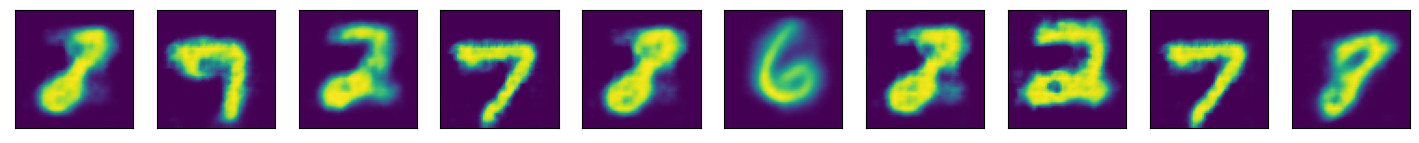

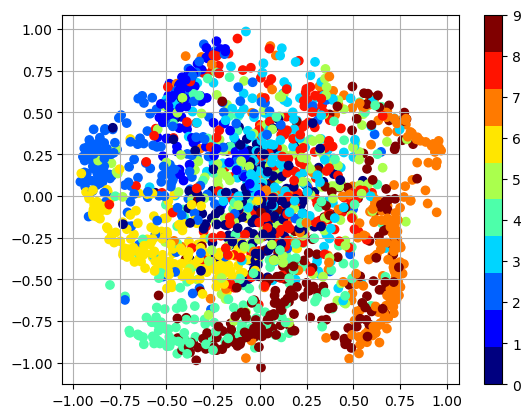

4001
lse_loss -1.9597268104553223
recon_loss 0.16957871615886688
4002
lse_loss -1.823347568511963
recon_loss 0.17317232489585876
4003
lse_loss -1.8953213691711426
recon_loss 0.1755092740058899
4004
lse_loss -1.9196743965148926
recon_loss 0.1773959845304489
4005
lse_loss -1.8460912704467773
recon_loss 0.177494615316391
4006
lse_loss -1.8595857620239258
recon_loss 0.17997686564922333
4007
lse_loss -1.9387645721435547
recon_loss 0.18605761229991913
4008
lse_loss -1.914224624633789
recon_loss 0.16975077986717224
4009
lse_loss -1.9214868545532227
recon_loss 0.17414486408233643
4010
lse_loss -1.8970727920532227
recon_loss 0.18332955241203308
4011
lse_loss -1.9396557807922363
recon_loss 0.17004713416099548
4012
lse_loss -1.8500003814697266
recon_loss 0.1805095374584198
4013
lse_loss -1.8075690269470215
recon_loss 0.17845384776592255
4014
lse_loss -1.9120492935180664
recon_loss 0.18353089690208435
4015
lse_loss -1.860391616821289
recon_loss 0.17662006616592407
4016
lse_loss -1.8606014251708984

4130
lse_loss -1.9437260627746582
recon_loss 0.18758587539196014
4131
lse_loss -1.8372201919555664
recon_loss 0.1806883066892624
4132
lse_loss -1.901388168334961
recon_loss 0.18055909872055054
4133
lse_loss -1.8955683708190918
recon_loss 0.1686779111623764
4134
lse_loss -1.93662691116333
recon_loss 0.17732450366020203
4135
lse_loss -1.9045257568359375
recon_loss 0.17589090764522552
4136
lse_loss -1.944404125213623
recon_loss 0.17319369316101074
4137
lse_loss -1.9384417533874512
recon_loss 0.17879967391490936
4138
lse_loss -1.885894775390625
recon_loss 0.17427782714366913
4139
lse_loss -1.930464744567871
recon_loss 0.184119313955307
4140
lse_loss -1.9055266380310059
recon_loss 0.17371031641960144
4141
lse_loss -1.9242057800292969
recon_loss 0.1765861213207245
4142
lse_loss -1.8981132507324219
recon_loss 0.18026646971702576
4143
lse_loss -1.9384584426879883
recon_loss 0.17631691694259644
4144
lse_loss -1.8147006034851074
recon_loss 0.17511193454265594
4145
lse_loss -1.8558015823364258
re

4259
lse_loss -1.8830766677856445
recon_loss 0.1814151108264923
4260
lse_loss -1.8769564628601074
recon_loss 0.18108642101287842
4261
lse_loss -1.9409008026123047
recon_loss 0.18557652831077576
4262
lse_loss -1.9043149948120117
recon_loss 0.1852477639913559
4263
lse_loss -1.950756549835205
recon_loss 0.176971435546875
4264
lse_loss -1.9756999015808105
recon_loss 0.17963871359825134
4265
lse_loss -1.9516749382019043
recon_loss 0.17189562320709229
4266
lse_loss -1.9426546096801758
recon_loss 0.17328707873821259
4267
lse_loss -1.9483537673950195
recon_loss 0.17804837226867676
4268
lse_loss -1.9642281532287598
recon_loss 0.18039624392986298
4269
lse_loss -1.9199342727661133
recon_loss 0.18005144596099854
4270
lse_loss -1.9360604286193848
recon_loss 0.1784021109342575
4271
lse_loss -1.9025297164916992
recon_loss 0.17336058616638184
4272
lse_loss -1.9737014770507812
recon_loss 0.1806701123714447
4273
lse_loss -1.956258773803711
recon_loss 0.18412190675735474
4274
lse_loss -1.8923969268798828

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=hp.M)

            # Backward
            loss = 0
            for key in data.keys():
                if 'kl_loss' in key:
                    loss = loss + data[key] * 0.00025
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=hp.M)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

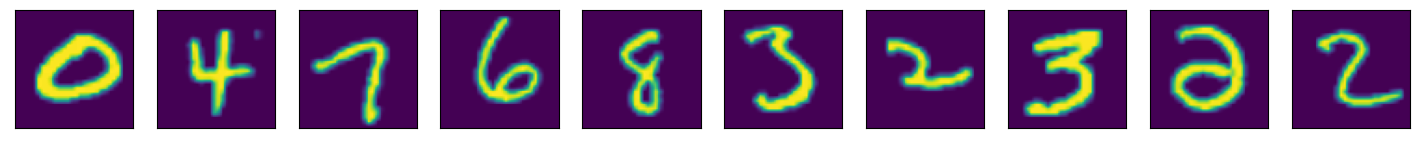

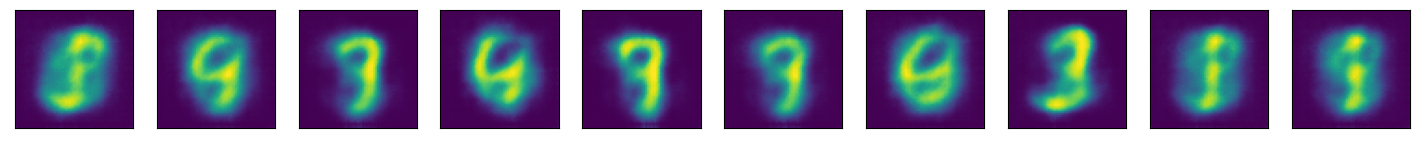

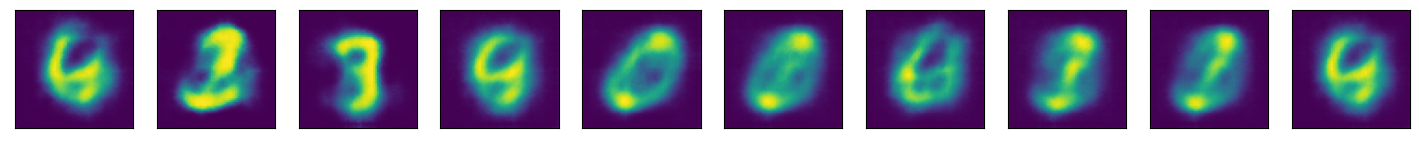

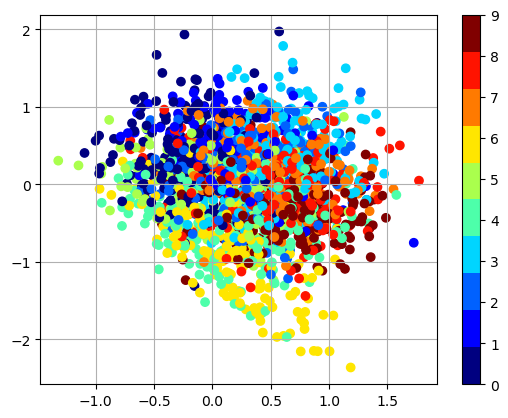

In [17]:
import matplotlib.pyplot as plt
display.clear_output()

batch = next(iter(test_loader))
data = preprocess(batch)

model = model_list[0]
model.eval()
with torch.no_grad():
    data = model(data, M=hp.M)

plot(data['x'])
plot(data['y'])

with torch.no_grad():
    z = torch.randn(10, hp.z_dim).to(device)
    y = model.sample(z)
    plot(y)

import matplotlib.pyplot as plt
_z = data['z'].data.cpu().numpy()
plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
plt.grid()
plt.colorbar()
plt.show()